In [1]:
from IPython.display import Image


## Purpose :
#### Predict NYC Taxi trip duration in `RMSLE` metric ( Root Mean Squared Logarithmic Error) 

- https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation



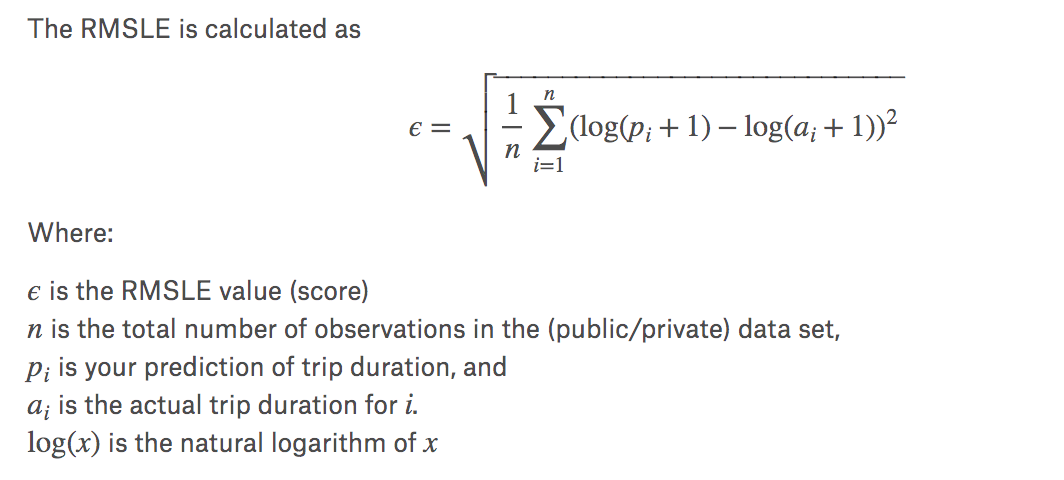

In [2]:
Image(filename='../NYC_Taxi_Trip_Duration/documents/RMSLE.png') 


## Process : 
    - 0 FEATURE ENGINEERING 
    - 0'DATA CLEANING 
    - 1 SIMPLE MODELING 
        -1.1 linear regression
        -1.2 lasso regression
        -1.3 decision tree regression
        -1.4 random forest regression 
        -1.5 xgboost
        -1.x logistic regression ***
    - 2 SELECT MODELS 
        -2.1 parameter select 
        -2.2 model tuning
    - 3 PREDICTION ENSEMBLE 

In [3]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
from IPython.display import Image 

Populating the interactive namespace from numpy and matplotlib


In [191]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

In [5]:
# basic feature extract 

def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff 
    df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
    df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    return df_


# get weekday
import calendar
def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_train.pickup_datetime,coerce=True).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_
    



In [228]:
df_train_ = basic_feature_extract(df_train)

In [229]:
df_train_ = get_duration(df_train_)

In [230]:
df_train_ = get_weekday(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:25: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [231]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


## 0) Feature engineering 

In [221]:
# feature extract

from sklearn.cluster import MiniBatchKMeans

###  distance 
# https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-377?scriptVersionId=1369021

# Haversine distance
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads
def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


# get direction (arc tangent angle)
def get_direction(lat1, lng1, lat2, lng2):
    # theta
    AVG_EARTH_RADIUS = 6371  #  km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


# PCA to transform longitude and latitude
# to improve decision tree performance 
from sklearn.decomposition import PCA
def pca_lon_lat(dftrain,dftest):
    coords = np.vstack \
            ((dftrain[['pickup_latitude', 'pickup_longitude']].values,
              dftrain[['dropoff_latitude', 'dropoff_longitude']].values,
              dftest[['pickup_latitude', 'pickup_longitude']].values,
              dftest[['dropoff_latitude', 'dropoff_longitude']].values))
    pca = PCA().fit(coords)
    dftrain['pickup_pca0'] = pca.transform(dftrain[['pickup_latitude', 'pickup_longitude']])[:, 0]
    dftrain['pickup_pca1'] = pca.transform(dftrain[['pickup_latitude', 'pickup_longitude']])[:, 1]
    dftrain['dropoff_pca0'] = pca.transform(dftrain[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    dftrain['dropoff_pca1'] = pca.transform(dftrain[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    dftest['pickup_pca0'] = pca.transform(dftest[['pickup_latitude', 'pickup_longitude']])[:, 0]
    dftest['pickup_pca1'] = pca.transform(dftest[['pickup_latitude', 'pickup_longitude']])[:, 1]
    dftest['dropoff_pca0'] = pca.transform(dftest[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    dftest['dropoff_pca1'] = pca.transform(dftest[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    return dftrain,dftest 


# get lon & lat clustering for following avg location speed calculation
def get_clustering(df):
    coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))
    df_ = df.copy()
    sample_ind = np.random.permutation(len(coords))[:500000]
    kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
    df_.loc[:, 'pickup_cluster'] = kmeans.predict(df_[['pickup_latitude', 'pickup_longitude']])
    df_.loc[:, 'dropoff_cluster'] = kmeans.predict(df_[['dropoff_latitude', 'dropoff_longitude']])
    return df_



# get Average speed for pickup location (taxi velocity)
def avg_speed(df):
    df_ = df.copy()
    df_.loc[:, 'pickup_lat_'] = np.round(df_['pickup_latitude'], 3)
    df_.loc[:, 'pickup_long_'] = np.round(df_['pickup_longitude'], 3)
    gby_cols = ['pickup_lat_', 'pickup_long_']
    coord_speed = df_.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_speed.columns = ['pickup_lat_','pickup_long_','avg_area_speed_h']
    # merge avg area speed and original dataframe
    df_ = pd.merge(df_, coord_speed,  how='outer')
    return df_





### ======================== ###

def get_features(df):
    # km 
    df_ = df.copy()
    ###  USING .loc making return array ordering 
    # distance
    df_.loc[:, 'distance_haversine'] = get_haversine_distance(
                      df_['pickup_latitude'].values,
                      df_['pickup_longitude'].values,
                      df_['dropoff_latitude'].values,
                      df_['dropoff_longitude'].values)
    df_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                      df_['pickup_latitude'].values,
                      df_['pickup_longitude'].values,
                      df_['dropoff_latitude'].values,
                      df_['dropoff_longitude'].values)
    # direction 
    df_.loc[:, 'direction'] = get_direction(df_['pickup_latitude'].values,
                                          df_['pickup_longitude'].values, 
                                          df_['dropoff_latitude'].values, 
                                          df_['dropoff_longitude'].values)
    # Get Average driving speed 
    # km/hr
    # (km/sec = 3600 * (km/hr))
    df_.loc[:, 'avg_speed_h'] = 3600 * df_['distance_haversine'] / df_['trip_duration']
    df_.loc[:, 'avg_speed_m'] = 3600 * df_['distance_manhattan'] / df_['trip_duration']
    
    return df_



In [198]:
#kmeans

In [222]:
#df_train_.loc[:, 'pickup_cluster'] = kmeans.predict(df_train_[['pickup_latitude', 'pickup_longitude']])
#df_train_.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train_[['dropoff_latitude', 'dropoff_longitude']])
#df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
#df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])
#t1 = dt.datetime.now()
#print('Time till clustering: %i seconds' % (t1 - t0).seconds)

In [223]:
#for gby_col in ['pickup_hour', 'pickup_date','pickup_cluster', 'dropoff_cluster']:
#    gby = df_train_.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'trip_duration']]
#    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
#    df_train_ = pd.merge(df_train_, gby, how='left', left_on=gby_col, right_index=True)
    #df_test = pd.merge(df_test, gby, how='left', left_on=gby_col, right_index=True)



In [224]:
#for gby_cols in [ ['pickup_cluster'], 
#                 ['pickup_cluster', 'dropoff_cluster']]:
#    coord_speed = df_train_.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
#    coord_count = df_train_.groupby(gby_cols).count()[['id']].reset_index()
#    coord_stats = pd.merge(coord_speed, on=gby_cols)
    #coord_stats = coord_stats[coord_stats['id'] > 100]
#    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
#    df_train_ = pd.merge(df_train_, coord_stats, how='left', on=gby_cols)
    #test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [188]:
#df_train_.columns

In [225]:
df_train_.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,trip_duration_gby_pickup_cluster,avg_speed_h_gby_dropoff_cluster,avg_speed_m_gby_dropoff_cluster,trip_duration_gby_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster_x,cnt_pickup_cluster_dropoff_cluster_x,avg_speed_h_pickup_cluster,cnt_pickup_cluster,avg_speed_h_pickup_cluster_dropoff_cluster_y,cnt_pickup_cluster_dropoff_cluster_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,866.692722,12.152009,15.988706,769.364785,10.472536,711.0,13.517148,36794.0,10.472536,711.0
1,id3570508,1,2016-03-15 10:21:28,2016-03-15 10:41:09,2,-73.982285,40.768200,-73.978012,40.751068,N,...,866.692722,13.533584,17.719212,927.753627,9.842614,545.0,13.517148,36794.0,9.842614,545.0
2,id3413393,2,2016-01-25 21:40:01,2016-01-25 21:46:55,1,-73.982208,40.768120,-73.996117,40.753700,N,...,866.692722,12.230455,15.585494,840.188563,13.757999,683.0,13.517148,36794.0,13.757999,683.0


In [232]:
# get all feature engineering features 
df_train_ = get_features(df_train_)

In [233]:
# PCA lon & lat 
df_train_,df_test_ = pca_lon_lat(df_train_,df_test)

In [234]:
# add avg area speed 
df_train_ = avg_speed(df_train_)

In [235]:
# get clustering 
df_train_ = get_clustering(df_train_)

In [236]:

df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,avg_speed_m,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,pickup_lat_,pickup_long_,avg_area_speed_h,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,13.730901,0.007691,0.017053,-0.009666,0.013695,40.768,-73.982,11.999492,93,69


In [238]:
#df_train_.columns

## 0') Data cleaning 

In [15]:
# data cleaning help function


# just simple remove too big /small data points in features, will do further after
# data cleaning analysis

def clean_data(df):
    df_ = df.copy()
    # remove potential distance outlier 
    df_ = df_[(df_['distance_haversine'] < df_['distance_haversine'].quantile(0.95))&
         (df_['distance_haversine'] > df_['distance_haversine'].quantile(0.05))]
    df_ = df_[(df_['distance_manhattan'] < df_['distance_manhattan'].quantile(0.95))&
         (df_['distance_manhattan'] > df_['distance_manhattan'].quantile(0.05))]
    # remove potential  trip duration outlier 
    # trip duration should less then 0.5 day and > 10 sec normally
    df_ = df_[(df_['trip_duration']  < 12*3600) & (df_['trip_duration'] > 10)]
    df_ = df_[(df_['trip_duration'] < df_['trip_duration'].quantile(0.95))&
         (df_['trip_duration'] > df_['trip_duration'].quantile(0.05))]
    # remove potential speed outlier  
    df_ = df_[(df_['avg_speed_h']  < 100) & (df_['avg_speed_h'] > 0)]
    df_ = df_[(df_['avg_speed_m']  < 100) & (df_['avg_speed_m'] > 0)]
    df_ = df_[(df_['avg_speed_h'] < df_['avg_speed_h'].quantile(0.95))&
         (df_['avg_speed_h'] > df_['avg_speed_h'].quantile(0.05))]
    df_ = df_[(df_['avg_speed_m'] < df_['avg_speed_m'].quantile(0.95))&
         (df_['avg_speed_m'] > df_['avg_speed_m'].quantile(0.05))]
    # potential passenger_count outlier 
    df_ = df_[(df_['passenger_count']  <= 6) & (df_['passenger_count'] > 0)]
    
    return df_
       
   

In [64]:
#df_train_.groupby('avg_speed_h').count().sort('')
#df_train_linear_.passenger_count.value_counts(sort=False)

## 1) Simple modeling 

In [146]:
#  modeling help function 

from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def sample_split(df):
    #data =  data[selected_feature]
    relevent_cols = list(df)
    data=df.values.astype(float)             
    Y = data[:,0]
    X = data[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test,X,Y


def reg_analysis(model, df):
    # get train, test set amd X,y here (for cross-validation) 
    X_train, X_test, y_train, y_test,X,Y = sample_split(df)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # Cross-validation score
    cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
    print ('cv model score = ',cross_val_score(model, X, Y, cv=cv))
    # Model score
    print ('Model score = ',model.score(X_test,y_test))
    # Mean squared log error
    # https://www.kaggle.com/wiki/RootMeanSquaredError
    #print ('Mean squared log error = ', mean_squared_error(prediction, y_test))
    # RMSLE score
    sum=0.0
    for x in range(len(prediction)):
        p = np.log(prediction[x]+1)
        r = np.log(y_test[x]+1)
        sum = sum + (p - r)**2
    print ('RMSLE score =  ',(sum/len(prediction))**0.5)
    return model
    

def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5


In [18]:
#df_train_.columns

### 1-1) linear regression

In [19]:
df_train_linear_ = clean_data(df_train_)

In [20]:
linear_feature = ['trip_duration', 
                  'distance_haversine',
                  'distance_manhattan']

In [21]:
# train, test seperate 
# 70% train, 30% test 
X_train, X_test, y_train, y_test,X,Y = sample_split(df_train_linear_[linear_feature])

In [147]:
from sklearn import linear_model
linear_model = linear_model.LinearRegression()
#reg_analysis(linear_model,X_train, X_test, y_train, y_test)
reg_analysis(linear_model,df_train_linear_[linear_feature])

cv model score =  [ 0.65755797  0.65583015  0.65714061  0.65664139]
Model score =  0.658844338268
RMSLE score =   0.278263507068


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Linear model score : 0.658844338268


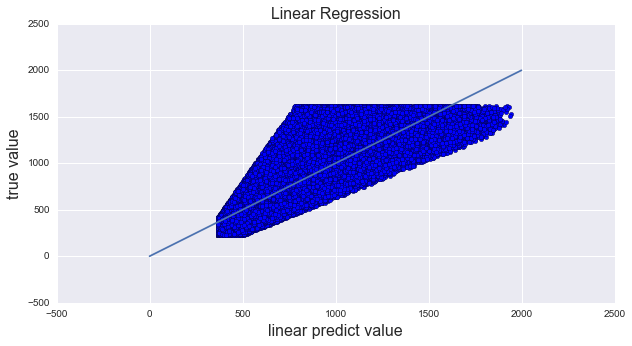

In [73]:
# Linear model 

from sklearn import linear_model

#fitting
linear_model = linear_model.LinearRegression()
linear_model.fit(X_train,y_train)
y_linear_fit = linear_model.predict(X_test)
print ('Linear model score :', linear_model.score(X_test,y_test))

# visualize 
plt.figure(figsize=(10,5))
plt.scatter(y_linear_fit,y_test, label = 'training points')
# hardcode here, just want a y=x line 
x = range(0,2000)
y = range(0,2000)
plt.plot(x, y)

# plot labels
plt.xlabel('linear predict value',fontsize=16);
plt.ylabel('true value',fontsize=16);
plt.title('Linear Regression',fontsize=16)
plt.show()


## 1-2) lasso regression

In [24]:
df_train_lasso_ = clean_data(df_train_)

In [25]:
lasso_feature = ['trip_duration', 
                 'vendor_id', 'passenger_count',
                 'direction','pickup_latitude',
                 'pickup_hour','pickup_month', 
                 'pickup_weekday','dropoff_hour',
                 'dropoff_month','distance_haversine',
                 'distance_manhattan']

In [148]:
from sklearn import linear_model
lasso_model = linear_model.Lasso(alpha=0.5)
reg_analysis(lasso_model,df_train_lasso_[lasso_feature])

cv model score =  [ 0.66079167  0.65887355  0.66038926  0.65987688]
Model score =  0.66219430932
RMSLE score =   0.27700613958


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### 1-3) decision tree regression

In [150]:
df_train_.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_year',
       'pickup_month', 'pickup_weekday', 'dropoff_date', 'dropoff_hour',
       'dropoff_year', 'dropoff_month', 'dropoff_weekday', 'trip_duration_cal',
       'pickup_week_', 'pickup_weekday_', 'distance_haversine',
       'distance_manhattan', 'direction', 'avg_speed_h', 'avg_speed_m',
       'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
       'pickup_lat_', 'pickup_long_', 'avg_area_speed_h'],
      dtype='object')

In [100]:
df_train_tree_ = clean_data(df_train_)

In [151]:
tree_feature = ['trip_duration', 'vendor_id', 
                'passenger_count','pickup_pca0', 
                'pickup_pca1','dropoff_pca0',
                'dropoff_pca1','pickup_hour','pickup_month',
                'dropoff_hour','dropoff_month','direction',
                'distance_haversine','pickup_weekday',
                'distance_manhattan']

In [152]:
# before adding avg_speed_h, but add PCA lon & lat 
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model = reg_analysis(tree_model,df_train_tree_[tree_feature])

cv model score =  [ 0.60494724  0.60497398  0.60605205  0.60618557]
Model score =  0.60657682125
RMSLE score =   0.296015920007


In [30]:
# after adding avg_speed_h
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model = reg_analysis(tree_model,df_train_tree_[tree_feature])

cv model score =  [ 0.99994147  0.99994118  0.99994193  0.99994153]
Model score =  0.999942222842
RMSLE score =   0.00304993426495


### 1-4) random forest regression 

In [31]:
df_train_rf_ = clean_data(df_train_.head(1000))

In [153]:
rf_feature = ['trip_duration', 'vendor_id', 
               'passenger_count','pickup_pca0',
               'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
               'pickup_hour','pickup_month',
                'dropoff_hour','dropoff_month', 'direction',
                'distance_haversine','pickup_weekday',
                'distance_manhattan']

In [154]:
# before adding avg_speed_h, but add PCA lon & lat 
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
reg_analysis(rf_model,df_train_rf_[rf_feature])

cv model score =  [ 0.65469017  0.67499523  0.56093701  0.64206034]
Model score =  0.647672041396
RMSLE score =   0.245996974143


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [34]:
# after adding avg_speed_h
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
reg_analysis(rf_model,df_train_rf_[rf_feature])

cv model score =  [ 0.9415114   0.95704802  0.96051964  0.96922046]
Model score =  0.95680286563
RMSLE score =   0.0787767678025


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

#### After  re-train models with New features : `avg_speed_h`, `avg_speed_m` ..
 We found out the RMSLE score is `significantly better` than before,
 since `Trip Duration ≈ Distance/avg_speed`; However, dropoff time is `not available` in `test dataset`, so we will use `loaction clustering` method to get avg_speed in clusters approach
 this. 
 

### 1-5) xgboost

In [35]:
#df_train_xgb_ = clean_data(df_train_.head(1000))
#df_train_xgb_ = clean_data(df_train_)

In [36]:
#xgb_feature = ['trip_duration', #'distance_haversine',
#                  'distance_manhattan']

In [37]:
#import xgboost as xgb
#xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                           colsample_bytree=1, max_depth=7)

In [38]:
#reg_analysis(xgboost_model,df_train_xgb_[xgb_feature])

In [39]:
#xgboost_model.predict(X_test)

In [40]:
#df_train_xgb_[xgb_feature]

### 1-x) logistic regression *** (need to fix )

In [41]:
#logistic_feature = ['trip_duration', #'distance_haversine',
#       'distance_manhattan']
#df_train_logistic_ = clean_data(df_train_)
# only run 5000 data points here, since logistics start running slow when data >10k
#X_train, X_test, y_train, y_test = sample_split(df_train_logistic_[logistic_feature].head(5000))
#X_train, X_test, y_train, y_test = sample_split(df_train_logistics_[logistics_feature])
#from sklearn.linear_model import LogisticRegression
# http://www.jianshu.com/p/bbdeb356057e
# using all CPUs with n_jobs=-1
# process will run faster with solver='sag' 
#logistic_model = LogisticRegression(n_jobs=-1,tol = 0.1,solver='sag')
#reg_analysis(logistic_model,X_train, X_test, y_train, y_test)